In [1]:
import torch
import matplotlib.pyplot as plt

import online_gp
import gpytorch

In [2]:
import pandas as pd

fx_rawdata = pd.read_csv('https://raw.githubusercontent.com/trungngv/cogp/master/data/fx/fx2007-processed.csv',
                        header=None)

inputs = torch.arange(0, fx_rawdata[3].shape[0]).view(-1,1).float()
targets = torch.from_numpy(fx_rawdata[3].values).float() 

inputs, targets = inputs[:60], targets[:60]

tmean = targets.mean()
tstd = targets.std()
targets = (targets - tmean) / tstd

imean = inputs.mean()
istd = inputs.std()
inputs = (inputs - imean) / istd

In [3]:
def fit_model(mll, model, optimizer, x, y, num_steps=1000, verbose=True):
    for i in range(num_steps):
        loss = -mll(model(x), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % (num_steps // 10 if num_steps > 10 else 1) == 0 and verbose:
            print("Loss: ", loss)

In [4]:
def make_basic_plot(model, x, y, old_x=None, old_y=None, bounds=(-6., 6.)):
    model.eval()
    with torch.no_grad():
        test_x = torch.linspace(*bounds).view(-1,1)
        pred_dist = vargp_model(test_x)
        pred_induc = vargp_model(vargp_model.variational_strategy.inducing_points.data.view(-1,1))
        
    plt.plot(test_x, pred_dist.mean, label = "Predictive Mean")
    plt.fill_between(test_x.view(-1), *[x.detach() for x in pred_dist.confidence_region()], alpha = 0.3)
    
    plt.scatter(x, y, color = "black", label = "Current Data")
    plt.scatter(vargp_model.variational_strategy.inducing_points.data, pred_induc.mean.detach(), 
            color = "red", marker="x", label = "Inducing Points")
    if old_x is not None:
        plt.scatter(old_x, old_y, color = "grey", alpha = 0.5, label = "Old Data")
        
    plt.legend()
    plt.xlabel("x", fontsize = 16)
    plt.ylabel("y", fontsize = 16)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
vargp_model = online_gp.models.VariationalGPModel(
    torch.linspace(-2., 0., 20), 
    streaming=False, 
    likelihood = likelihood,
    covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)
)
mll = gpytorch.mlls.VariationalELBO(likelihood=likelihood, model=vargp_model, num_data=20, beta = 1.0)

In [6]:
optimizer = torch.optim.Adam(list(vargp_model.parameters()) + list(likelihood.parameters()), lr = 0.01)

In [7]:
fit_model(mll, vargp_model, optimizer, inputs[:20], targets[:20])

Loss:  tensor(2.6014, grad_fn=<NegBackward>)
Loss:  tensor(1.5728, grad_fn=<NegBackward>)
Loss:  tensor(1.3268, grad_fn=<NegBackward>)
Loss:  tensor(1.0099, grad_fn=<NegBackward>)
Loss:  tensor(0.7458, grad_fn=<NegBackward>)
Loss:  tensor(0.7050, grad_fn=<NegBackward>)
Loss:  tensor(0.6938, grad_fn=<NegBackward>)
Loss:  tensor(0.6854, grad_fn=<NegBackward>)
Loss:  tensor(0.6802, grad_fn=<NegBackward>)
Loss:  tensor(0.6792, grad_fn=<NegBackward>)


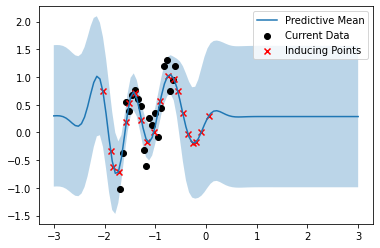

In [8]:
make_basic_plot(vargp_model, inputs[:20], targets[:20], bounds=(-3., 3))

In [9]:
vargp_model.update_variational_parameters(
    inputs[20:25], 
    targets[20:25], 
#    torch.linspace(-2., 1., 20).view(-1,1)
    vargp_model.variational_strategy.inducing_points.clone().detach()
)

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


In [10]:
vargp_model.zero_grad()
vargp_model.train()

mll = gpytorch.mlls.VariationalELBO(
    likelihood=likelihood, 
    model=vargp_model, 
    num_data=5, 
    beta = 1.0,
    combine_terms=True
)
optimizer = torch.optim.Adam(list(vargp_model.parameters()) + list(likelihood.parameters()), lr = 0.01)

In [11]:
fit_model(mll, vargp_model, optimizer, inputs[20:25], targets[20:25], num_steps=5)

Loss:  tensor(4.3757, grad_fn=<NegBackward>)
Loss:  tensor(5.6243, grad_fn=<NegBackward>)
Loss:  tensor(3.3360, grad_fn=<NegBackward>)
Loss:  tensor(3.1353, grad_fn=<NegBackward>)
Loss:  tensor(3.0503, grad_fn=<NegBackward>)


/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/lazy/cached_cg_lazy_tensor.py:162: ExtraComputationWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([20, 20]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  ExtraComputationWarning,


(-3.0, 3.0)

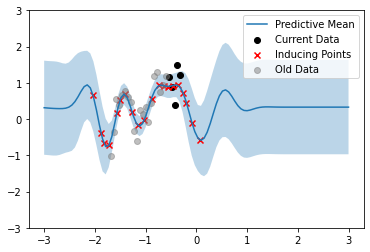

In [12]:
make_basic_plot(vargp_model, inputs[20:25], targets[20:25], old_x=inputs[:20], old_y=targets[:20], bounds=(-3., 3.))
plt.ylim((-3., 3))

## Fit in Online Mode


In [18]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
vargp_model = online_gp.models.VariationalGPModel(
    torch.linspace(-2., -1., 20), 
    streaming=False, 
    likelihood = likelihood,
    covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3)
)
mll = gpytorch.mlls.VariationalELBO(likelihood=likelihood, model=vargp_model, num_data=5, beta = 1.0)

optimizer = torch.optim.Adam(list(vargp_model.parameters()) + list(likelihood.parameters()), lr = 1e-3)

fit_model(mll, vargp_model, optimizer, inputs[:5], targets[:5])


Loss:  tensor(2.5373, grad_fn=<NegBackward>)
Loss:  tensor(2.0867, grad_fn=<NegBackward>)
Loss:  tensor(1.7988, grad_fn=<NegBackward>)
Loss:  tensor(1.6213, grad_fn=<NegBackward>)
Loss:  tensor(1.5080, grad_fn=<NegBackward>)
Loss:  tensor(1.4315, grad_fn=<NegBackward>)
Loss:  tensor(1.3753, grad_fn=<NegBackward>)
Loss:  tensor(1.3298, grad_fn=<NegBackward>)
Loss:  tensor(1.2888, grad_fn=<NegBackward>)
Loss:  tensor(1.2490, grad_fn=<NegBackward>)


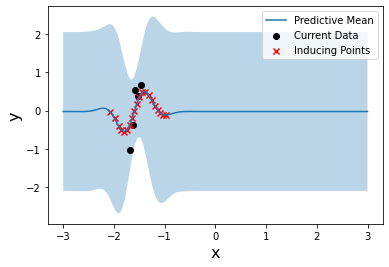

In [19]:
make_basic_plot(vargp_model, inputs[:5], targets[:5], bounds=(-3., 3))

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/lazy/cached_cg_lazy_tensor.py:162: ExtraComputationWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([20, 20]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  ExtraComputationWarning,


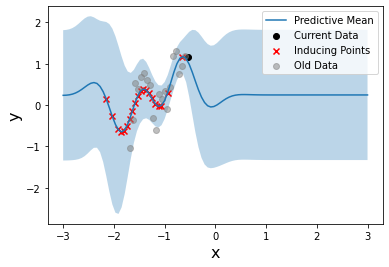

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/lazy/cached_cg_lazy_tensor.py:162: ExtraComputationWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([20, 20]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  ExtraComputationWarning,


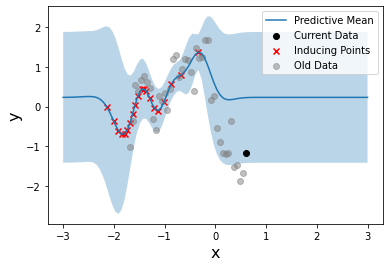

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/lazy/cached_cg_lazy_tensor.py:162: ExtraComputationWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([20, 20]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  ExtraComputationWarning,


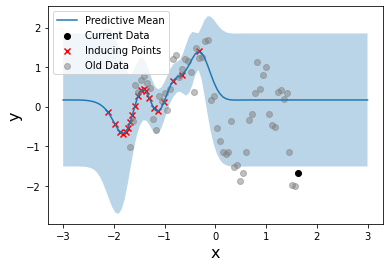

/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/Users/wesleymaddox/Documents/GitHub/gpytorch/gpytorch/lazy/cached_cg_lazy_tensor.py:162: ExtraComputationWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([20, 20]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  ExtraComputationWarning,


In [20]:
step = 1

for i in range(5, 60, step):
    next_x = inputs[i:i+step]
    next_y = targets[i:i+step]
    
    with gpytorch.settings.cholesky_jitter(1e-3):
        vargp_model.update_variational_parameters(
            next_x, 
            next_y, 
            vargp_model.variational_strategy.inducing_points.clone().detach()
        )
    
    vargp_model.zero_grad()
    vargp_model.train()

    mll = gpytorch.mlls.VariationalELBO(
        likelihood=likelihood, 
        model=vargp_model, 
        num_data=step, 
        beta = 1.0,
        combine_terms=True
    )
    
    fit_model(mll, vargp_model, optimizer, next_x, next_y, num_steps=100, verbose=False)
    
    if i == 20 or i == 40 or i == 58:
        make_basic_plot(
            vargp_model, 
            next_x, 
            next_y, 
            old_x=inputs[:i], 
            old_y=targets[:i], 
            bounds=(-3., 3.)
        )
        plt.show()


In [8]:
%pdb

Automatic pdb calling has been turned ON
